# Logistic Regression with Python
We will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/competitions/titanic/overview)

We'll be trying to predict a classification- survival or deceased.

We'll use a "semi-cleaned" version of the titanic dataset.

## Import Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
sns.set_style('whitegrid')

In [38]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import cufflinks as cf

init_notebook_mode(connected=True)
cf.go_offline()

## The Data

In [39]:
train = pd.read_csv('files/titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<hr>

## Exploratory Data Analysis

### Missing Data
We can use seaborn to create a simple heatmap to see where we are missing data!

<AxesSubplot: >

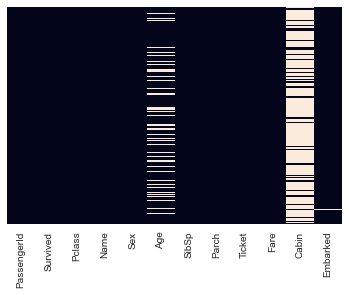

In [40]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)

In [41]:
len(train[train['Age'].isnull()==True]) / len(train['Age'])

0.19865319865319866

Roughly 20% of the Age data is missing. The propotion of Age missing is likely small enough for resonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are missing too much of the data. We'll probably drop this, or change ot to another feature like "Cabin Known: 1 or 0"

<AxesSubplot: xlabel='Survived', ylabel='count'>

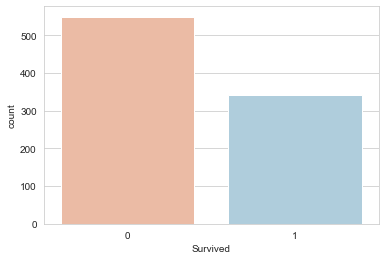

In [42]:
sns.countplot(data=train, x='Survived', palette='RdBu')

<AxesSubplot: xlabel='Survived', ylabel='count'>

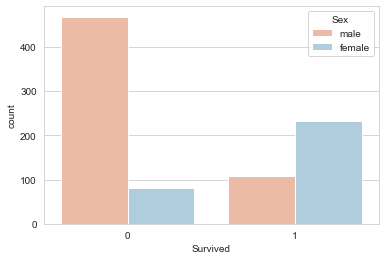

In [43]:
sns.countplot(data=train, x='Survived', hue='Sex', palette='RdBu')

<AxesSubplot: xlabel='Survived', ylabel='count'>

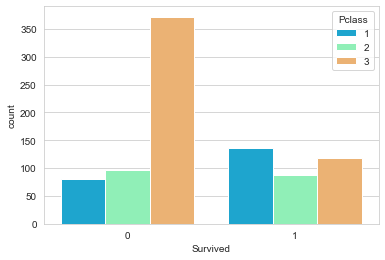

In [44]:
sns.countplot(data=train, x='Survived', hue='Pclass', palette='rainbow')

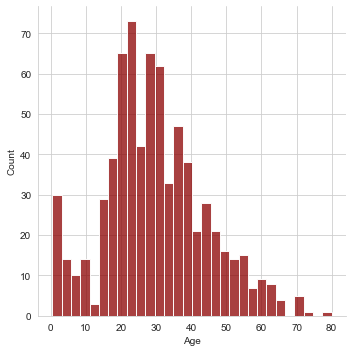

In [45]:
sns.displot(train['Age'].dropna(), bins=30, color='darkred')

<AxesSubplot: xlabel='SibSp', ylabel='count'>

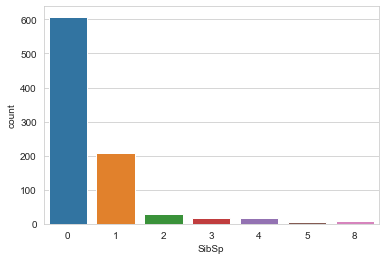

In [46]:
sns.countplot(data=train, x='SibSp')

<AxesSubplot: >

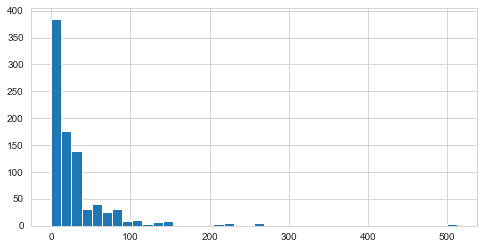

In [47]:
train['Fare'].hist(bins=40, figsize=(8,4))

### Cufflinks for plots

In [48]:
train['Fare'].iplot(kind='hist', bins=30)

<hr>

## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows.<br>
One way to do this is by filling in the mean age of all the passengers (imputation). However we can be smarter and check the average age by passenger class.

<AxesSubplot: xlabel='Pclass', ylabel='Age'>

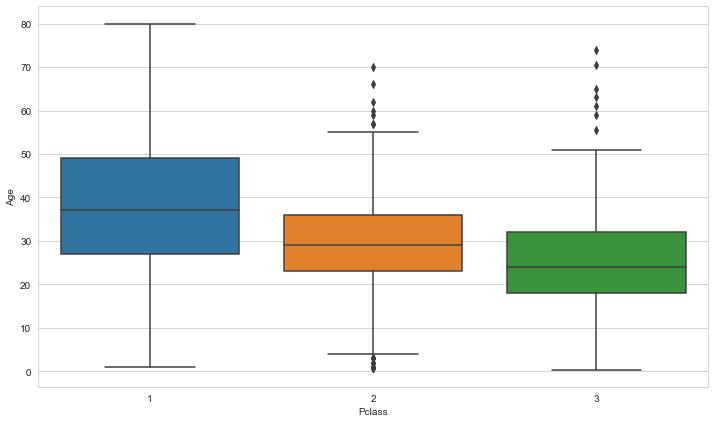

In [49]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass', y='Age', data=train)

In [50]:
train.groupby('Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [51]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):

      if Pclass==1:
          return 38
      elif Pclass==2:
          return 30
      else:
          return 25
  
    else:
      return Age
    

In [52]:
train['Age'] = train[['Age','Pclass']].apply(impute_age, axis=1)

<AxesSubplot: >

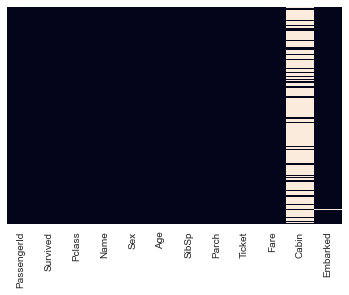

In [53]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)

Now, lets drop the Cabin column and the row in Embarked that is NaN.

In [54]:
train.drop('Cabin', axis=1, inplace=True)

In [55]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [56]:
train.dropna(inplace=True)

<hr>

## Converting Categorical Features
We'll need to convert categorical featurs to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [57]:
sex = pd.get_dummies(train['Sex'], drop_first=True)
embark = pd.get_dummies(train['Embarked'], drop_first=True)

In [58]:
train.drop(['Sex','Embarked','Name','Ticket'], axis=1, inplace=True)

In [59]:
train = pd.concat([train,sex,embark], axis=1)

In [60]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


<hr>

## Building a Logistic Regression model

### Train Test Split

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'male', 'Q', 'S'],
      dtype='object')

In [63]:
X = train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q', 'S']]
y = train['Survived']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Training and Predicting

In [65]:
from sklearn.linear_model import LogisticRegression

In [66]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

c:\python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [67]:
predictions = logmodel.predict(X_test)

<hr>

## Evaluation

In [68]:
from sklearn.metrics import classification_report

In [69]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       163
           1       0.85      0.69      0.76       104

    accuracy                           0.83       267
   macro avg       0.84      0.81      0.82       267
weighted avg       0.83      0.83      0.83       267



In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
confusion_matrix(y_test, predictions)

array([[150,  13],
       [ 32,  72]], dtype=int64)

<hr>

## Extra 
We will split PClass as it only has values from 1 to 3 and see how it effects outr model

In [72]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [73]:
p_class = pd.get_dummies(train['Pclass'], drop_first=True)
p_class.head()

,2,3
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1


In [74]:
train = pd.concat([train, p_class], axis=1)

In [75]:
train.drop(['PassengerId', 'Pclass'], axis=1, inplace=True)

In [76]:
train.head()

,Survived,Age,SibSp,Parch,Fare,male,Q,S,2,3
0,0,22.0,1,0,7.2500,1,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0
4,0,35.0,0,0,8.0500,1,0,1,0,1


In [77]:
X = train.drop('Survived', axis=1)
y = train['Survived']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [79]:
logmodel.fit(X_train, y_train)

c:\python39\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

c:\python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [80]:
predictions = logmodel.predict(X_test)

c:\python39\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [81]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       163
           1       0.84      0.68      0.75       104

    accuracy                           0.82       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.82      0.82       267



<hr>